In [1]:
import numpy as np
import tensorflow as tf

import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

%matplotlib inline
sns.set_style("whitegrid")

np.random.seed(1000)

In [2]:
mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 40).T

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 40).T

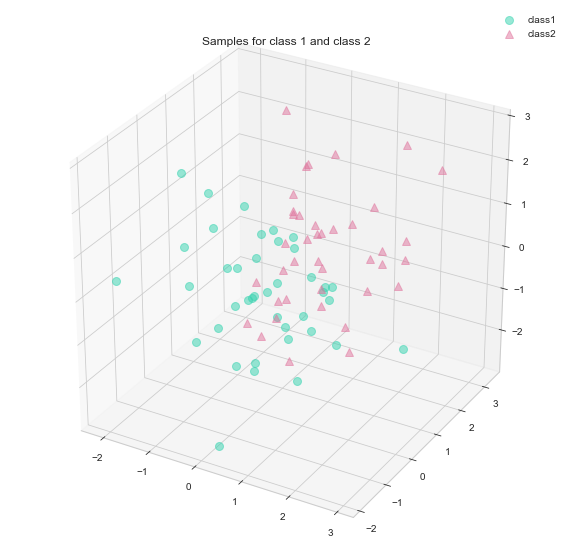

In [3]:
def plot_original(position):
    ax = fig.add_subplot(position, projection='3d')
    plt.rcParams['legend.fontsize'] = 10   
    ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:],
            'o', markersize=8, color='#33d3af', alpha=0.5, label='class1')
    ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:],
            '^', markersize=8, color='#e0749d', alpha=0.5, label='class2')

    plt.title('Samples for class 1 and class 2')
    ax.legend(loc='upper right');
    
fig = plt.figure(figsize=(10, 10))
plot_original(111)

#### 1. Taking the whole dataset ignoring the class labels

In [4]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)

x = tf.placeholder(tf.float32)
target_shape = tf.constant([3, 80])

assert_shape = tf.assert_equal(
    tf.shape(all_samples),
    target_shape,
    message="The matrix has not the dimensions 3x80")

with tf.Session() as sess:
    result = sess.run(assert_shape, feed_dict={x: all_samples})

#### 2. Computing the d-dimensional mean vector

In [5]:
x = tf.constant(all_samples)
mean_vector = tf.reduce_mean(x, 1)

with tf.Session() as sess:
    result = sess.run(mean_vector)

mean_vector = np.reshape(result, [3, 1])
print('Mean Vector:\n', mean_vector)

Mean Vector:
 [[0.59011366]
 [0.41180056]
 [0.26485755]]


#### 3.1 Computing the Scatter Matrix

In [6]:
sess = tf.InteractiveSession()

x = tf.placeholder(dtype=tf.float32)

yay = tf.tensordot(
    tf.subtract(tf.reshape(x, [3, 1]), mean_vector),
    tf.transpose(tf.subtract(tf.reshape(x, [3, 1]), mean_vector)),
    axes=1)

scatter_matrix = np.zeros((3,3))

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for i in range(all_samples.shape[1]):
        scatter_matrix += sess.run(yay, feed_dict={x: all_samples[:,i]})

print('Scatter Matrix:\n', scatter_matrix)#

Scatter Matrix:
 [[ 81.53706852   7.60617096   5.36926784]
 [  7.60617096 108.20076739  19.30223756]
 [  5.36926784  19.30223756 102.84493146]]


#### 3.2. Computing the Covariance Matrix (alternatively to the scatter matrix)

In [7]:
x = tf.constant(all_samples, dtype=tf.float32)
y = tf.constant(all_samples[0], dtype=tf.float32)

cov_mat = np.zeros((len(all_samples),len(all_samples)))

for i in range(len(all_samples)):
    for j in range(i+1):
        with tf.Session() as sess:
            z, op = tf.contrib.metrics.streaming_covariance(x[i], x[j])
            tf.global_variables_initializer().run()
            tf.local_variables_initializer().run()
            sess.run(z)

            cov_mat[i, j] = sess.run(op)

for i in range(len(all_samples)):
    for j in range(len(all_samples)-i -1):
        cov_mat[i, j+1+i] = cov_mat[j+1+i, i]
        
print('Covariance Matrix:\n', cov_mat)

Covariance Matrix:
 [[1.03211486 0.09628067 0.06796542]
 [0.09628067 1.36962986 0.24433213]
 [0.06796542 0.24433213 1.30183458]]


#### 4. Computing eigenvectors and corresponding eigenvalues

In [8]:
# eigenvectors and eigenvalues from the scatter matrix
x = tf.placeholder(dtype=tf.float32)
op = tf.linalg.eigh(x)
with tf.Session() as sess:
    tf.global_variables_initializer().run
    eig_val_sc, eig_vec_sc = sess.run(op, feed_dict={x: scatter_matrix})

In [9]:
# eigenvectors and eigenvalues from the covariance matrix
x = tf.placeholder(dtype=tf.float32)
op = tf.linalg.eigh(x)
with tf.Session() as sess:
    tf.global_variables_initializer().run
    eig_val_cov, eig_vec_cov = sess.run(op, feed_dict={x: cov_mat})

In [10]:
x = tf.placeholder(tf.float32)
target_shape = tf.constant([3, 80])

assert_shape = tf.assert_equal(
    tf.shape(all_samples),
    target_shape,
    message="The matrix has not the dimensions 3x80")

with tf.Session() as sess:
    result = sess.run(assert_shape, feed_dict={x: all_samples})

for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:,i].reshape(1,3).T
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    assert eigvec_sc.all() == eigvec_cov.all(), 'Eigenvectors are not identical'

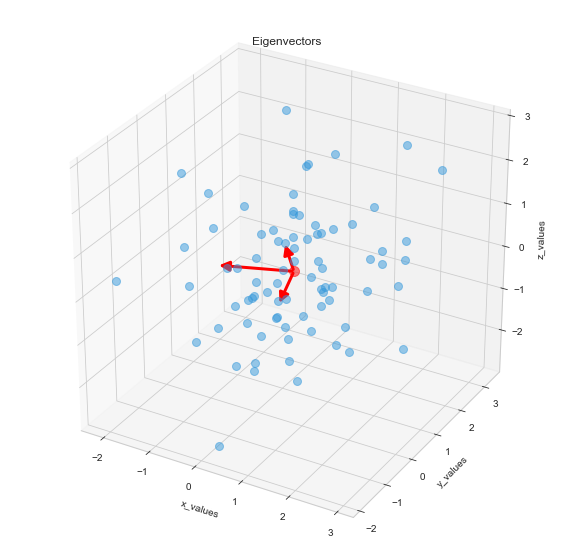

In [12]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])
        
        
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='#3498db', alpha=0.5)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors');

#### 5. Choosing k eigenvectors with the largest eigenvalues

In [13]:
k = 2
a = tf.placeholder(tf.float32)

select_k_largest = tf.nn.top_k(a, k=k).indices

with tf.Session() as sess:
    result = sess.run(select_k_largest, feed_dict={a: eig_val_sc})
    
to_append = []
for t in result:
    to_append.append([[i] for i in eig_vec_sc.T[t]])
    
redim = tf.concat(values=to_append, axis=1)

with tf.Session() as sess:
    matrix_w = sess.run(redim)
    print(matrix_w)

[[ 0.20013428  0.13697278]
 [ 0.7419057   0.6255528 ]
 [ 0.6399392  -0.768064  ]]


#### 6. Transforming the samples onto the new subspace

In [14]:
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
target_shape = tf.constant([2, 80])

assert_shape = tf.assert_equal(
    tf.shape(tf.tensordot(tf.transpose(x), y, 1)),
    target_shape,
    message="The matrix has not the dimensions 2x80")

with tf.Session() as sess:
    result = sess.run(assert_shape, feed_dict={x: matrix_w, y: all_samples})

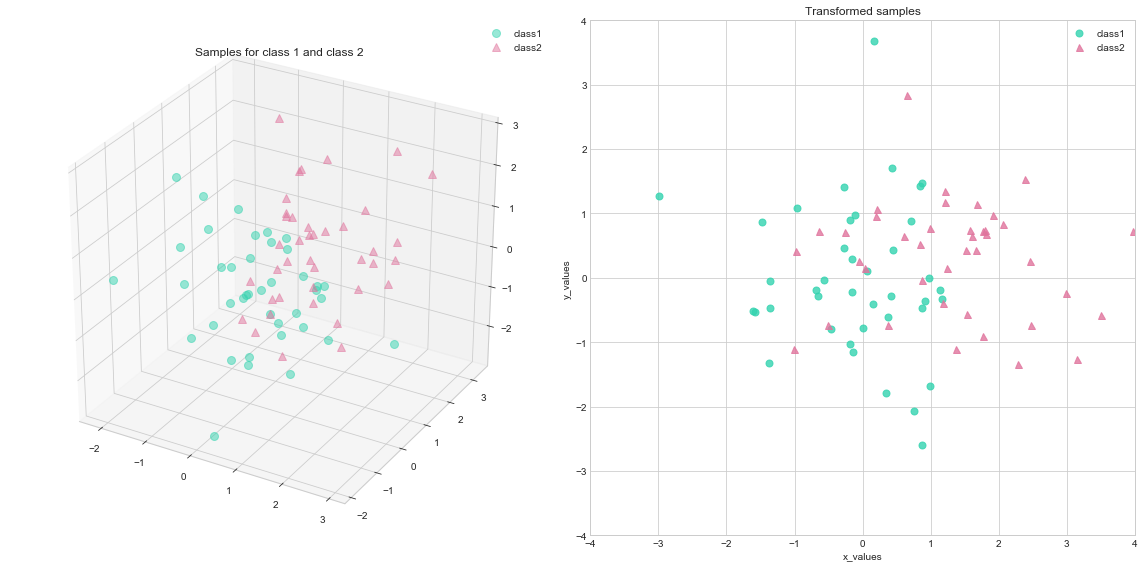

In [15]:
fig = plt.figure(figsize=(16, 8))

plot_original(121)

transformed = matrix_w.T.dot(all_samples)

ax = fig.add_subplot(122)
plt.plot(transformed[0,0:40], transformed[1,0:40], 'o', markersize=7, color='#33d3af', alpha=0.8, label='class1')
plt.plot(transformed[0,40:80], transformed[1,40:80], '^', markersize=7, color='#e0749d', alpha=0.8, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples')
plt.tight_layout()
plt.show()